# Data Cleaning

---

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#import seaborn as sns
#import altair as alt

In [3]:
metadata = pd.read_csv("data/metadata.csv")
print(metadata.shape)
metadata.head()

(10420, 4)


,filename,split,original,label
0,bztdemptfg.mp4,train,exxqlfpnbz.mp4,FAKE
1,qarqtkvgby.mp4,train,NaN,REAL
2,kujvvxpted.mp4,train,fdpisghkmd.mp4,FAKE
3,avznxuwvbx.mp4,train,dpevefkefv.mp4,FAKE
4,ehfmarmsvo.mp4,train,jawgcggquk.mp4,FAKE


In [46]:
metadata.tail()

,filename,split,original,label
10415,alrogmblmz.mp4,train,fimhhyetym.mp4,FAKE
10416,ubxlhztujz.mp4,train,epphrlkqhp.mp4,FAKE
10417,ucvpzauvoh.mp4,train,vpiqmvxclb.mp4,FAKE
10418,kjcstjpivk.mp4,train,krifcuqyay.mp4,FAKE
10419,adcnvlhawy.mp4,train,jswunuyhcq.mp4,FAKE


In [4]:
metadata.drop('split', axis = 1, inplace=True)

Based on the original dataset comprising of videos that are all 10 seconds long at 30 frames per second (FPS), I should expect the pre-processed dataset to consist of 300 images or frames of faces for each video. From browsing the pre-processed data, I encountered cases where frames misidentified as faces were present and cases with more than 1 face per frame (video featured more than 1 actor). I thus sought to investigate the number of frames across the whole dataset. Video filenames and their number of frames was obtained using a bash script (get_n_frames.sh) and written into a csv file (n_frames_df.csv).

In [5]:
n_frames_df = pd.read_csv("n_frames.csv", names=['filename', 'n_frames'])
n_frames_df.head()

,filename,n_frames
0,data/aaagqkcdis/,276
1,data/aaaoqepxnf/,300
2,data/aabdnomlru/,300
3,data/aabqyygbaa/,300
4,data/aafezqchru/,300


In [6]:
# remove extraneous characters from filename
n_frames_df['filename'] = n_frames_df['filename'].str.replace("data/", "").str.replace("/", "")

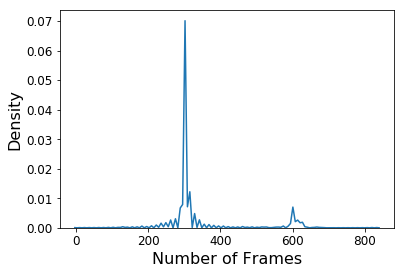

In [21]:
# look at the distribution of n frames in a density plot
ax = sns.distplot(n_frames_df['n_frames'], hist=False)
ax.set_xlabel('Number of Frames', fontsize = 16)
ax.set_ylabel('Density', fontsize = 16)
ax.tick_params(labelsize=12)

In [24]:
# write histogram as png
n_frames_hist = ax.get_figure()
n_frames_hist.savefig('figs/n_frames_hist.png')

There is some variability in the number of frames that were extracted from each video, with the majority of extracted frames falling between 200 and 400. There is also a noticeable group around 600 frames - these must be the videos that featured 2 actors. 

Since I will be using keras models which takes a non-variable input shape, I need all of my videos to have the same number of frames. I also need to consider whether 30 frames per second is necessary, as adjacent frames will be nearly identical. Considering my limited resources in time and computation, reducing down to 1 frame per second sounds like a reasonable idea. This also reduces the amount of padding I would need to do. First, I will disregard videos for which less than 200 or more than 400 face frames were extracted (outliers). 

In [7]:
# get videos for which over 400 or less than 200 frames were extracted during face detection
outliers = n_frames_df.loc[np.where((n_frames_df['n_frames']>400) | (n_frames_df['n_frames']<200))]['filename']
len(outliers)

1832

Recall that for each original video, several fakes were generated. So, if a real video was identified as an outlier but one or more of its derived fakes were not, those fakes would no longer have an associated original in the dataset. Let's check to see if there are any of these cases.

In [8]:
# get fakes associated with a real video that was called as an outlier
real_outlier_fakes = metadata[metadata['original'].isin(outliers + ".mp4")]['filename']

# from above, get those that were not called an outlier
outlier_assoc_fakes = real_outlier_fakes[~real_outlier_fakes.isin(outliers + ".mp4")].str.replace(".mp4", "")

# how many were not called an outlier
len(outlier_assoc_fakes)

51

There are 51 non-outlier fakes whose associated originals were idenfied to be an outlier. Let's add these to the outlier list.

In [9]:
outliers = outliers.append(outlier_assoc_fakes)

In [122]:
# write outlier filenames as txt file
outlier_paths = "data/" + outliers
outlier_paths.to_csv('n_frame_outliers.txt', index=0, header=False)

Using the exported n_frame_outliers.txt file, I archived the outliers video directories with the following bash command:

`xargs -a n_frame_outliers.txt mv -t data/archived/n_frame_outliers`

Can return an error: `mv: cannot stat '<path>'$'\r': No such file or directory`
Had to run the following for the bash command to work

`tr -d '\r' <n_frame_outliers.txt >n_frame_outliers_new.txt && mv n_frame_outliers_new.txt n_frame_outliers.txt`

I should also update the metadata file

In [10]:
outliers

5        aahncigwte
11       aansscoqsl
27       abjgxazkfk
30       abterabwrj
34       abzamapbpi
            ...    
10138    bfowhabcyv
10295    srbvyvchmm
10310    hudmutditr
10322    frcluhsyzk
10419    adcnvlhawy
Name: filename, Length: 1883, dtype: object

In [30]:
metadata = pd.read_csv("data/metadata.csv")

# encode labels as 0 (real) and 1 (fake)
metadata['label'] = metadata['label'].map({'REAL':0, 'FAKE':1})

# fill na values in original with value in filename (only relevant for real videos)
metadata['original'].fillna(metadata['filename'], inplace=True)

# remove '.mp4' from filename
metadata['filename'] = metadata['filename'].str.replace('.mp4', '')

# remove outliers
metadata = metadata[~metadata['filename'].isin(outliers)]

# change filename to be path to each image folder
metadata['filename'] = 'data_30/' + metadata['filename']

In [31]:
metadata.shape

(8537, 4)

In [32]:
# return proportion of classes
metadata['label'].value_counts() / metadata['label'].value_counts().sum()

1    0.877826
0    0.122174
Name: label, dtype: float64

The dataset consists of ~87.8% fake videos and ~12.2% real videos. This means that a model requires an accuracy of greater than 87.8% to be better than just simply guessing 'fake' on every video.

## Train-Test Split

The fact that there are multiple fake videos derived from each original video presents a concern regarding the train-test split. If I were to perform random stratification, videos derived from the same original would be present in both training and testing sets, thus breaking the *golden rule* of machine learning. To elaborate, while no two videos should be exactly the same, the similarity between videos orignating from the same source may bias the model such that it may be able to classify a video more easily if it has learned from related videos during training. Hence, I should ensure that each original and their derivatives or 'family' of videos are stratified such that they are mutually exclusive between the train and test sets.

In [95]:
np.random.seed(2006)

orig_files = metadata['original'].unique()

# randomly split original (real) videos 
mask = np.random.rand(len(orig_files)) < 0.8
train_mask = orig_files[mask]
test_mask = orig_files[~mask]

train = metadata[metadata['original'].isin(train_mask)]
test = metadata[metadata['original'].isin(test_mask)]

In [35]:
print(train.shape[0], test.shape[0])

6888 1649


In [96]:
print(train['label'].value_counts() / train['label'].value_counts().sum())
print(test['label'].value_counts() / test['label'].value_counts().sum())

1    0.878031
0    0.121969
Name: label, dtype: float64
1    0.876913
0    0.123087
Name: label, dtype: float64


In [101]:
train.drop(['split','original'], axis = 1, inplace=True)
test.drop(['split','original'], axis = 1, inplace=True)

C:\Users\Steph\Anaconda3\envs\neuralnetworks\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [105]:
train.to_csv('metadata_train.csv', index=False)
test.to_csv('metadata_test.csv', index=False)